# Logistic regression via gradient descent


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sys

In [ ]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

The random seed is set so results are repeatable.

In [ ]:
np.random.seed(0)

## Gradients

This code here is to compute the gradient of a function.

In [ ]:
def partials_at_x(f, n, x):
    h = 0.000001
    y = f(x)
    partial_derivs = np.zeros(n)
    for i in range(n):
        x[i] += h
        yh = f(x)
        x[i] -= h
        partial_derivs[i] = yh - y
    partial_derivs = partial_derivs/h
    return partial_derivs
    
def gradient(f, n):
    return lambda x: partials_at_x(f, n, x)

In [ ]:
# test the gradient() function

def f(x):
    return 2*x[0]**2 + x[0]*x[1]

# print the gradient of f
f_grad = gradient(f, 2)
xs = [ np.array(x) for x in [[1.0, 2.0], [0.0, 0.0], [2.0, -1.0]] ]
for x in xs:
    print('x: {}, f_grad(x): {}'.format(x, f_grad(x)))

x: [1. 2.], f_grad(x): [6.000002 1.      ]
x: [0. 0.], f_grad(x): [2.e-06 0.e+00]
x: [ 2. -1.], f_grad(x): [7.000002 2.      ]


## Gradient descent

In gradient descent we want to find the value of x that minimizes (or maximizes) a function f.  We do this by starting with some x, computing the value of the gradient of f at x, and then using that value to make an adjustment to x.

In [ ]:
def grad_descent(f, n, alpha=0.1, n_iterations=1000, threshold=0.001):
  """ Returns the value x for which function f(x) is minimum, and also
  the values of x along the path of gradient descent.  
  The algorithm terminates when iteration limit is reach or when the
  L1 norm of the change to x is below the threshold.  """
  
  f_grad = gradient(f, n)

  x = np.random.rand(n)           # note random starting point
  xs = [x.copy()]
  for i in range(n_iterations):
    delta = alpha * f_grad(x)
    x -= delta
    xs.append(x.copy())           # the copy is needed, else all values in xs will be the same
    if np.sum(np.absolute(delta)) < threshold:     # L1 norm
      return x, xs

  print('warning: reached iteration limit')
  return x, xs

In [ ]:
# test the grad_descent() function

# test on some 1D functions
f1 = lambda x: (x[0] - 1)**2
f2 = lambda x: 0.2*(x[0]**2) + np.sin(x[0])
for f in [f1, f2]:
  x, xs = grad_descent(f, 1)
  print('x = {}, f(x) = {:0.3f}'.format(x, f(x)))
    
# test on 2D function
f = lambda x: (x[0]-1)**2 + (x[1]+1)**2 + 2.0
x, xs = grad_descent(f, 2)
print('x = {}, f(x) = {:0.3f}'.format(x, f(x)))

x = [0.99667033], f(x) = 0.000
x = [-1.10462872], f(x) = -0.649
x = [ 0.99923113 -0.99701226], f(x) = 2.000


Plot the value of the loss function as gradient descent proceeds.

In [ ]:
def plot_descent(f, xs):
  """ plot value of function f using history xs of gradient descent """
  plt.plot([f(x) for x in xs])
  plt.xlabel('iteration')
  plt.ylabel('f(x)')
  plt.title('Progress of gradient descent')
  plt.grid();

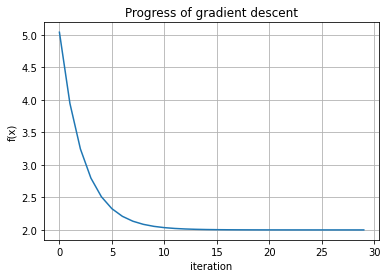

In [ ]:
# plot progress of gradient descent for function f
x, xs = grad_descent(f, 2)
plot_descent(f, xs)

## Binary Logistic regression

The key idea for training is that we want to use gradient descent to find the model parameters that minimize the loss function.  For binary classification with logistic regression, the loss function is "log loss".

#### Heart disease data set

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/heart.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        270 non-null    int64  
 1   sex        270 non-null    int64  
 2   chestpain  270 non-null    int64  
 3   restbp     270 non-null    int64  
 4   chol       270 non-null    int64  
 5   sugar      270 non-null    int64  
 6   ecg        270 non-null    int64  
 7   maxhr      270 non-null    int64  
 8   angina     270 non-null    int64  
 9   dep        270 non-null    float64
 10  exercise   270 non-null    int64  
 11  fluor      270 non-null    int64  
 12  thal       270 non-null    int64  
 13  output     270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 29.7 KB


Prepare the training data set.

In [ ]:
df['output'] -= 1         # 0 = ok, 1 = heart disease

predictors = ['age', 'restbp', 'maxhr']
target = 'output'
X = df[predictors].values
y = df[target].values

# scale the data
X = StandardScaler().fit_transform(X)

# augment the data
X1 = np.c_[np.ones(X.shape[0]), X]        # add new first column of 1's

print(X1.shape)
print(y.shape)

(270, 4)
(270,)


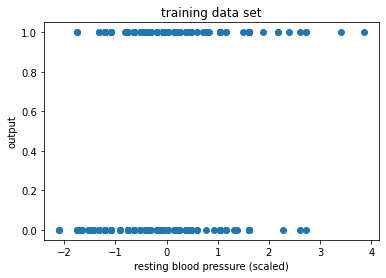

In [ ]:
# plot output by rest BP
plt.scatter(X[:,1], y, );
plt.title('training data set')
plt.xlabel('resting blood pressure (scaled)')
plt.ylabel('output');

### Log loss

Note that to compute the loss we need both the model parameters and the training data.

#### Problem 1

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [ ]:
# test sigmoid()

print(sigmoid(-1.0))
print(sigmoid(0))
print(sigmoid(0.8))

0.2689414213699951
0.5
0.6899744811276125


#### Problem 2

In [ ]:
# implement log loss yourself, not with a library function
def log_loss(b, X1, y):
    loss = []
    m = X1.shape[0]

    for i in range(m):
      prediction = sigmoid(b.dot(X1[i]))
      loss.append(y[i] * np.log(prediction) + (1 - y[i]) * np.log(1 - prediction))

    return -np.sum(loss) / m

In [ ]:
# test log_loss() by computing the loss for various
# values of linear parameters b
m = 4
bs = np.array([[-0.2, 0.1, 0.3, -1.0],
              [0.8, 0.5, 0.6, 0.9],
              [0.05, 0.08, 0.02, 0.8]])

for i in range(bs.shape[0]):
    b = bs[i]
    print('b: {}, log_loss(b): {:0.3f}'.format(b, log_loss(b, X1, y)))

b: [-0.2  0.1  0.3 -1. ], log_loss(b): 0.582
b: [0.8 0.5 0.6 0.9], log_loss(b): 1.021
b: [0.05 0.08 0.02 0.8 ], log_loss(b): 0.923


### Gradient descent with log loss

Now we can put together our gradient descent function and log_loss function to perform logistic regression.

We create a loss function that is log_loss() with our training data X1, y "hardwired" in.

#### Problem 3

In [ ]:
loss = lambda b: log_loss(b, X1, y)
b_estimated, history = grad_descent(loss, 4)
print(b_estimated)

[-0.24640406  0.07479957  0.30294116 -0.93332161]


Compute training loss and training accuracy.  Use a threshold of 0.5 when computing accuracy.

In [ ]:
pred = sigmoid(X1.dot(b_estimated))    
training_loss = loss(b_estimated)
training_acc = (y == (pred > 0.5)).mean()

print('training loss: {:0.3f}, training accuracy: {:0.3f}'.format(training_loss, training_acc))

training loss: 0.582, training accuracy: 0.711


This plot shows how log loss decreases during gradient descent.

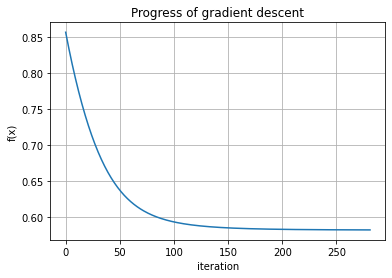

In [ ]:
plot_descent(loss, history)

### Compare to the result from Scikit-Learn

In [ ]:
clf = LogisticRegression()
clf.fit(X, y)

print('Model coefficients:')
print(clf.intercept_)
print(clf.coef_)

print('\nScikit-Learn training accuracy: {:0.3f}'.format(clf.score(X,y)))     # training accuracy

Model coefficients:
[-0.2463097]
[[ 0.04820012  0.31247721 -0.94939172]]

Scikit-Learn training accuracy: 0.704


## Multi-class logistic regression

If we have a multi-class classification problem, then we need to use a separate linear model for each output class.  If we have 3 output class, for example, from each input we will get a vector of three output values.  In multi-class logistic regression, we transform this vector to a vector of probabilities using the softmax function.

#### Iris data set

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/iris.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
df['species'].value_counts()

versicolor    50
setosa        50
virginica     50
Name: species, dtype: int64

Preprocess the data

In [ ]:
predictors = df.columns[:4]
X = df[predictors].values
y_raw = df['species'].values

# one-hot encoding of the target
df = pd.get_dummies(df)
target = df.columns[4:]
y = df[target].values

# scale the data
X = StandardScaler().fit_transform(X)

# augment the data
X1 = np.c_[np.ones(X.shape[0]), X]        # add new first column of 1's

print(X1.shape)
print(y.shape)
print(y_raw.shape)

(150, 5)
(150, 3)
(150,)


### Softmax

#### Problem 4

In [ ]:
#### Implement softmax yourself
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

Test softmax

In [ ]:
print(softmax(np.array([1.7, 2.4, 0.5])))
print(softmax(np.array([-0.2, 1.2, -0.1])))

[0.30166396 0.60747661 0.09085944]
[0.16232789 0.65827205 0.17940006]


#### Making predictions

We have a separate linear model for each output class.  If we have k output classes, and n predictors, then we need n+1 parameters for each class.  Instead of keeping the parameters for each class separate, we can put them in a single matrix B.  Each row of B will contain the parameters for one class.  In other words, B will have k rows and n+1 columns.

Think about the matrix multiplication that is needed here.  Previously we got a single output value for each training example by computing X1.dot(b).  How shall we combine X1 and B to get an array of outputs, one for each class?

Make predictions using a random set of parameters of the linear model.  Each row in array pred is a prediction.

In [ ]:
B = np.random.rand(X1.shape[1], y.shape[1])
pred = X1.dot(B)
pred[:5]

array([[-1.79440354, -1.02495559,  0.05587703],
       [-2.04197974, -2.00050214, -0.86088335],
       [-2.30642572, -1.69000608, -0.56916167],
       [-2.324334  , -1.77903546, -0.66800388],
       [-1.90190191, -0.84189648,  0.22444893]])

Apply softmax to each row, so that the values in each row sum to 1.

In [ ]:
pred = np.apply_along_axis(softmax, 1, pred)
print(pred[:5])

[[0.10504005 0.22673675 0.66822321]
 [0.18866878 0.19665887 0.61467236]
 [0.1171775  0.21704605 0.66577645]
 [0.12554662 0.21658341 0.65786997]
 [0.08149559 0.23522779 0.68327662]]


The generalization of log loss to more than 2 classes is cross entropy.

### Cross-entropy

#### Problem 5

In [ ]:
def cross_entropy(pred, y):
    """ cross-entropy of arrays pred and y, where y is one-hot encoded """
    return np.mean(-np.log(pred[y == 1]))

def cross_entropy_loss(b, X1, y):
    B = b.reshape((X1.shape[1], y.shape[1]))
    pred = X1.dot(B)
    y_pred = np.apply_along_axis(softmax, 1, pred)
    return cross_entropy(y_pred, y)

Test cross_entropy() and cross_entropy_loss().

In [ ]:
print(cross_entropy(np.array([0.98, 0.01, 0.01]), np.array([1, 0, 0])))
print(cross_entropy(np.array([0.90, 0.05, 0.05]), np.array([1, 0, 0])))
print(cross_entropy(np.array([0.40, 0.20, 0.20]), np.array([1, 0, 0])))
print(cross_entropy(np.array([0.40, 0.20, 0.20]), np.array([0, 1, 0])))

# class examples
print(cross_entropy(np.array([0.3, 0.61, 0.09]), np.array([0, 1, 0])))
print(cross_entropy(np.array([0.3, 0.61, 0.09]), np.array([1, 0, 0])))

0.020202707317519466
0.10536051565782628
0.916290731874155
1.6094379124341003
0.4942963218147801
1.2039728043259361


In [ ]:
# checking an example from lecture
print(cross_entropy(np.array([[0.1, 0.5, 0.4],
                              [0.1, 0.1, 0.8],
                              [0.2, 0.6, 0.2]]),
                    np.array([[1, 0, 0],
                              [0, 0, 1],
                              [0, 1, 0]])))

1.0121847560247488


### Gradient descent with cross-entropy.

Using gradient descent, softmax, and cross entropy loss we can perform multi-class logistic regression.

#### Problem 6

In [ ]:
loss = lambda b: cross_entropy_loss(b, X1, y) 
num_parameters = 15 
b_estimated, history = grad_descent(loss, num_parameters, alpha=0.5, n_iterations=400, threshold=0.00001)
print(b_estimated)

[ 0.07220324  3.3688566  -1.71313402 -0.98973188  1.27655259  0.91423354
  2.12894222  0.16243843 -0.49257505 -2.39038444  0.1098489   3.52904675
 -1.62851411 -0.46070803  4.33171562]


In [ ]:
print(cross_entropy_loss(b_estimated, X1, y))

0.09041396997266515


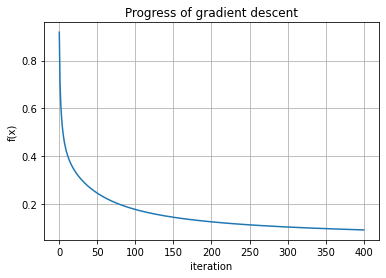

In [ ]:
plot_descent(loss, history)

Compute training set accuracy

In [ ]:
B1 = b_estimated.reshape((X1.shape[1], y.shape[1]))
pred = np.apply_along_axis(np.argmax, 1, X1.dot(B1))  
y1d  = np.apply_along_axis(np.argmax, 1, y)

# training accuracy
print('gradient descent training accuracy: {:0.3f}'.format((pred == y1d).mean()))

gradient descent training accuracy: 0.973


Compare results to Scikit Learn

In [ ]:
clf = LogisticRegression()
clf.fit(X, y_raw)

print('Scikit-Learn training accuracy: {:0.3f}'.format(clf.score(X,y_raw)))

Scikit-Learn training accuracy: 0.973
